In [1]:
'''
Evaluate trained PredNet on KITTI sequences.
Calculates mean-squared error and plots predictions.
'''

import os
import numpy as np
from six.moves import cPickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Flatten, UpSampling3D

from prednet import PredNet
from data_utils import SequenceGenerator
from kitti_settings import *

os.environ['KMP_DUPLICATE_LIB_OK']='True'

n_plot = 40
batch_size = 10
nt = 1

weights_file = os.path.join(WEIGHTS_DIR, 'tensorflow_weights/prednet_kitti_weights.hdf5')
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')
test_file = os.path.join(DATA_DIR, 'X_test.hkl')
test_sources = os.path.join(DATA_DIR, 'sources_test.hkl')

# Load trained model
f = open(json_file, 'r')
json_string = f.read()
f.close()
train_model = model_from_json(json_string, custom_objects = {'PredNet': PredNet})
train_model.load_weights(weights_file)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
# Create testing model (to output predictions)
layer_config = train_model.layers[1].get_config()
#layer_config['output_mode'] = 'prediction'
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
#input_shape = list(train_model.layers[0].batch_input_shape[1:])


In [4]:
input_shape = list(train_model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))
#inputs = Input(shape = (1,3,128,160))    # dim_1, channels, dim_2, dim_3
copied_inputs = UpSampling3D(size = (10,1,1), data_format="channels_last")(inputs)

In [3]:
train_model.layers[1].get_config()

{'name': 'prednet_1',
 'trainable': True,
 'batch_input_shape': (None, None, None),
 'dtype': 'float32',
 'return_sequences': True,
 'return_state': False,
 'go_backwards': False,
 'stateful': False,
 'unroll': False,
 'implementation': 0,
 'stack_sizes': [3, 48, 96, 192],
 'R_stack_sizes': [3, 48, 96, 192],
 'A_filt_sizes': [3, 3, 3],
 'Ahat_filt_sizes': [3, 3, 3, 3],
 'R_filt_sizes': [3, 3, 3, 3],
 'pixel_max': 1.0,
 'error_activation': 'relu',
 'A_activation': 'relu',
 'LSTM_activation': 'tanh',
 'LSTM_inner_activation': 'hard_sigmoid',
 'data_format': 'channels_first',
 'extrap_start_time': None,
 'output_mode': 'error'}

In [5]:
predictions = test_prednet(copied_inputs)
test_model = Model(inputs=inputs, outputs=predictions)

In [6]:
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 3, 128, 160)    0         
_________________________________________________________________
up_sampling3d_2 (UpSampling3 (None, 10, 3, 128, 160)   0         
_________________________________________________________________
prednet_1 (PredNet)          (None, 10, 4)             6915948   
Total params: 6,915,948
Trainable params: 6,915,948
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Create testing image
test_generator = SequenceGenerator(test_file, test_sources, nt, sequence_start_mode='unique', data_format=data_format)
X_test = test_generator.create_all()
init_image = X_test[0:1]
X_hat = test_model.predict([init_image], batch_size)
#if data_format == 'channels_first':
#    X_test = np.transpose(X_test, (0, 1, 3, 4, 2))
#    X_hat = np.transpose(X_hat, (0, 1, 3, 4, 2))

In [8]:
X_hat.shape

(1, 10, 4)

In [44]:
init_image.shape

(1, 1, 3, 128, 160)

In [21]:
my_test_input = np.random.normal(size=(1,1,3,128,160))

In [22]:
my_test_input.shape

(1, 1, 3, 128, 160)

In [11]:
test_model.predict([init_image], batch_size)

array([[[0.11393905, 0.03285335, 0.03655666, 0.01850791],
        [0.01844493, 0.02624465, 0.03039164, 0.02163076],
        [0.0077996 , 0.02195416, 0.01977164, 0.01669387],
        [0.00556509, 0.02037708, 0.01507402, 0.01413527],
        [0.004547  , 0.0198917 , 0.01335491, 0.01305663],
        [0.00395614, 0.01977248, 0.0124061 , 0.01249539],
        [0.00359965, 0.01973161, 0.01192908, 0.01227811],
        [0.00337577, 0.01973534, 0.0116391 , 0.01211441],
        [0.00324655, 0.01972657, 0.01147921, 0.01193816],
        [0.00318594, 0.01970933, 0.01137774, 0.01176092]]], dtype=float32)

In [23]:
test_model.predict(my_test_input)

array([[[0.40905055, 0.18689671, 0.15236554, 0.07822029],
        [0.39292514, 0.17339268, 0.11882459, 0.07675168],
        [0.39659208, 0.17916441, 0.13466594, 0.07652984],
        [0.3967748 , 0.17958088, 0.133374  , 0.08524973],
        [0.39665452, 0.17983726, 0.13101171, 0.07711497],
        [0.3968341 , 0.17955993, 0.13356516, 0.08047494],
        [0.39704034, 0.17977951, 0.13258423, 0.08182928],
        [0.39688402, 0.17959735, 0.13343546, 0.08060671],
        [0.39698097, 0.1797161 , 0.13338874, 0.08121498],
        [0.39693817, 0.1797007 , 0.13318665, 0.08078043]]], dtype=float32)

In [26]:
loss = test_model.output[0,0,0]

In [42]:
# define a placeholder for the input image_vector (the flattened image)
input_img = test_model.input

# define the loss function - which is precisely just the mean of the probability of the given character across the batch
loss = K.mean(test_model.output[0,0,:])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [51]:
# run gradient ascent for n steps

#input_img_data = my_test_input
#input_img_data = init_image
n = 100
step = 0.1
for i in range(n):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

    print('Current loss value:', loss_value)

Current loss value: 0.5987469
Current loss value: 0.6092725
Current loss value: 0.6197998
Current loss value: 0.63034874
Current loss value: 0.6409055
Current loss value: 0.6514772
Current loss value: 0.66205657
Current loss value: 0.6726458
Current loss value: 0.6832495
Current loss value: 0.6938614
Current loss value: 0.7044859
Current loss value: 0.71512496
Current loss value: 0.7257836
Current loss value: 0.7364455
Current loss value: 0.7471195
Current loss value: 0.7578088
Current loss value: 0.7685143
Current loss value: 0.7792179
Current loss value: 0.7899461
Current loss value: 0.8006818
Current loss value: 0.81143314
Current loss value: 0.82220435
Current loss value: 0.832972
Current loss value: 0.8437503
Current loss value: 0.85454386
Current loss value: 0.8653416
Current loss value: 0.87615144
Current loss value: 0.88696086
Current loss value: 0.8977754
Current loss value: 0.90861595
Current loss value: 0.9194509
Current loss value: 0.9302998
Current loss value: 0.9411645
Cu

In [31]:
input_img_data.shape

(1, 1, 3, 128, 160)

In [39]:
def convert_to_display_format(batched_input):
    disp = np.transpose(batched_input[0,0,:,:,:],(1,2,0))
    return disp

In [36]:
disp_image = input_img_data[0,0,:,:,:]
disp_image = np.transpose(disp_image, (1,2,0))

In [37]:
disp_image.shape

(128, 160, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


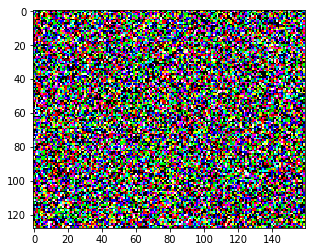

In [40]:
plt.imshow(convert_to_display_format(my_test_input))

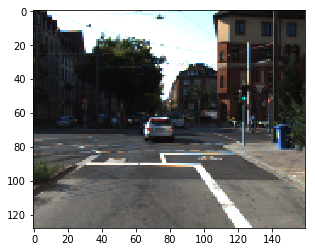

In [45]:
plt.imshow(convert_to_display_format(init_image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


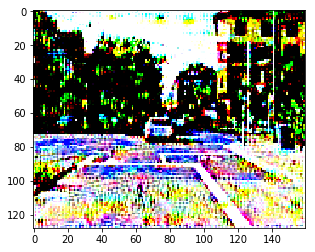

In [48]:
plt.imshow(convert_to_display_format(input_img_data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


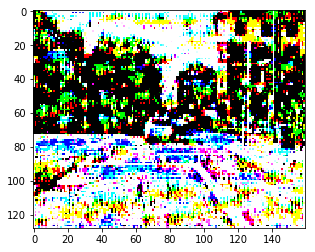

In [52]:
plt.imshow(convert_to_display_format(input_img_data))